# GNSS Review

## Initialise Python environment

In [2]:
# Standard modules import first 
import pandas as pd
import numpy as np
import pymap3d as pm
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

# Add personnal module after (error otherwise)
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader

In [3]:
# Prepare matplotlib environment 
plt.style.use('plot_style.mplstyle')

In [4]:
def getSystemStr(letter):
    match letter:
        case 'G':
            return "GPS"
        case 'E':
            return "Galileo"
        case 'R':
            return "GLONASS"
        case 'C':
            return "BeiDou"

## Prepare log data

This function define a dictionnary containing all the required data about the log.

In [5]:
def getLogDictionnary(device_name, filepath, time_range):
    return {
        'device_name' : device_name,
        'filepath'    : filepath,
        'time_range'  : time_range
    }

We add the logs in a common to compare them all together.

In [6]:
logs = []


logs.append(getLogDictionnary(
    "Google Pixel 7",
    "../.data/static/gnss_log_GooglePixel7_2023_02_17_09_55_01.txt",
    (None, None)
))

logs.append(getLogDictionnary(
    "OnePlus Nord 2",
    "../.data/static/gnss_log_OnePlusNord2_2023_03_03_10_55_04.txt",
    (None, None)
))

logs.append(getLogDictionnary(
    "Samsung A52",
    "../.data/static/gnss_log_SamsungA52_2023_03_17_14_12_30.txt",
    (None, None)
))

logs.append(getLogDictionnary(
    "Xiaomi 11T",
    "../.data/static/gnss_log_Xiaomi11T_2023_03_03_09_56_06.txt",
    (None, None)
))

ref_enu = [61.449219, 23.856267, 166.0]

All the log are parsed and transformed into panda dataframes.

In [7]:
# Parse logg
for log in logs:
    log['content'] = LogReader(log['filepath'], ['Raw', 'Fix'])


In [8]:
# Compute additional errors
for log in logs:
    log['content'].raw = log['content'].raw.sort_values(by=['prn', 'datetime'])
    
    dt = log['content'].raw.groupby('prn')['datetime'].diff().dt.seconds.values
    
    doppler = log['content'].raw.groupby('prn')['PseudorangeRateMetersPerSecond'].diff().div(dt, axis=0,)
    log['content'].raw['DopplerError'] = doppler
    
    phases = log['content'].raw.groupby('prn')['AccumulatedDeltaRangeMeters'].diff().div(dt, axis=0,)
    log['content'].raw['PhaseVelocitiy'] = phases
    log['content'].raw['PhaseError'] = phases.diff().div(dt, axis=0,)

    log['content'].raw['PhaseMinusDoppler'] = log['content'].raw['PhaseVelocitiy'] - log['content'].raw['PseudorangeRateMetersPerSecond']

# df = logs[0]['content'].raw.loc[logs[0]['content'].raw['prn'].isin(['G30-L1']), ['prn', 'AccumulatedDeltaRangeMeters', 'PhaseError']]

# logs[0]['content'].raw.groupby('prn')['datetime'].diff().dt.seconds.values

# Position analysis

### Compute ENU errors

We define conversion function from geodetic to ENU.

In [8]:
def convert2ENU(lat, lon, alt, ref):
    east, north, up = pm.geodetic2enu(lat, lon, alt, ref[0], ref[1], ref[2])
    return {"east":east, "north":north, "up":up}

def getHorizontalError(east, north):
    error = np.sqrt(north**2 + east**2)
    return {"2D_error":error}

def get3DError(east, north, up):
    error = np.sqrt(north**2 + east**2 + up**2)
    return {"2D_error":error}

In [9]:
# Compute ENU errors
for log in logs:
    log['content'].fix[["east", "north", "up"]] = log['content'].fix.apply(
        lambda row: convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log['content'].fix[["2D_error"]] = log['content'].fix.apply(
        lambda row: getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log['content'].fix[["3D_error"]] = log['content'].fix.apply(
        lambda row: get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')
    
logs[0]['content'].fix

,provider,timestamp,datetime,latitude,longitude,altitude,east,north,up,2D_error,3D_error
0,FLP,1.676621e+09,2023-02-17 07:55:01.785,61.449239,23.856239,165.599991,-1.488271,2.273365,-0.400010,2.717193,2.746479
1,GPS,1.676621e+09,2023-02-17 07:55:02.000,61.449239,23.856239,169.884517,-1.490790,2.278091,3.884516,2.722527,4.743587
2,FLP,1.676621e+09,2023-02-17 07:55:04.020,61.449240,23.856239,165.599991,-1.504274,2.295653,-0.400010,2.744606,2.773602
3,FLP,1.676621e+09,2023-02-17 07:55:05.021,61.449240,23.856239,165.599991,-1.514942,2.306797,-0.400010,2.759776,2.788614
4,FLP,1.676621e+09,2023-02-17 07:55:06.020,61.449240,23.856238,165.599991,-1.520277,2.306797,-0.400010,2.762707,2.791516
...,...,...,...,...,...,...,...,...,...,...,...
3166,FLP,1.676623e+09,2023-02-17 08:40:02.068,61.449242,23.856266,163.699997,-0.048009,2.585394,-2.300004,2.585840,3.460720
3167,GPS,1.676623e+09,2023-02-17 08:40:03.999,61.449242,23.856266,164.741893,-0.038247,2.576234,-1.258107,2.576518,2.867278
3168,FLP,1.676623e+09,2023-02-17 08:40:04.068,61.449242,23.856266,163.899994,-0.037340,2.574250,-2.100007,2.574521,3.322377
3169,GPS,1.676623e+09,2023-02-17 08:40:04.999,61.449242,23.856266,164.728125,-0.031024,2.575131,-1.271875,2.575318,2.872269


### Plotting functions

In [10]:
# Plot ENU
def plotENU(logs):

    # Params
    minor_ticks = 0.5
    major_ticks = 2
    minor_ticks_up = 1
    major_ticks_up = 5
    ylim_east = 5
    ylim_north = ylim_east
    ylim_up = 15

    # Init
    fig, axs = plt.subplots(3, figsize=(8,6))
    plt.suptitle('East / North / Up errors')
    for log in logs:
        df = log['content'].fix.loc[log['content'].fix['provider'].isin(['GPS']), ["datetime", "east", "north", "up"]]
        df['east'].plot(ax=axs[0], label=log['device_name'])
        df['north'].plot(ax=axs[1], label=log['device_name'])
        df['up'].plot(ax=axs[2], label=log['device_name'])
        
    # East
    axs[0].set_ylabel("East [m]")
    axs[0].set_ylim(-ylim_east, ylim_east)
    axs[0].yaxis.set_major_locator(MultipleLocator(major_ticks))
    axs[0].yaxis.set_major_formatter('{x:.0f}')
    axs[0].yaxis.set_minor_locator(MultipleLocator(minor_ticks))

    # East
    axs[1].set_ylabel("North [m]")
    axs[1].set_ylim(-ylim_north, ylim_north)
    axs[1].yaxis.set_major_locator(MultipleLocator(major_ticks))
    axs[1].yaxis.set_major_formatter('{x:.0f}')
    axs[1].yaxis.set_minor_locator(MultipleLocator(minor_ticks))

    # Set ticks up
    axs[2].set_ylabel("Up [m]")
    axs[2].yaxis.set_major_locator(MultipleLocator(major_ticks_up))
    axs[2].yaxis.set_major_formatter('{x:.0f}')
    axs[2].yaxis.set_minor_locator(MultipleLocator(minor_ticks_up))
    axs[2].set_ylim(-ylim_up, ylim_up)
        
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower left",
            mode="expand", ncol=len(labels))

    fig.tight_layout(rect=[0, 0.03, 1, 1])


In [11]:
# Plot EN
def plotEN(logs):
    minor_ticks = 0.5
    major_ticks = 2
    lim = 5
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, axs = plt.subplots(1, figsize=(6,6))
    fig.suptitle('East/North errors')
    i = 0
    for log in logs:
        df = log['content'].fix.loc[log['content'].fix['provider'].isin(['GPS']), ["datetime", "east", "north", "up"]]
        df.plot(x='east', y='north', kind='scatter', label=log['device_name'], color=colors[i], s=6, zorder=3, ax=axs)
        i+=1
    
    plt.grid(zorder=0)
    plt.axis('square')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel('East [m]')
    plt.ylabel('North [m]')
    axs.yaxis.set_major_locator(MultipleLocator(major_ticks))
    axs.yaxis.set_major_formatter('{x:.0f}')
    axs.yaxis.set_minor_locator(MultipleLocator(minor_ticks))
    axs.xaxis.set_major_locator(MultipleLocator(major_ticks))
    axs.xaxis.set_major_formatter('{x:.0f}')
    axs.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
        
    fig.tight_layout()


In [12]:
# Plot ENU histogram
def plotHistENU(logs):

    lim = 5
    nb_bins = 51

    for log in logs:
        fig, axs = plt.subplots(1, figsize=(6,4))
        fig.suptitle(f"Histogram ENU errors ({log['device_name']})")
        pos = log['content'].fix.loc[log['content'].fix['provider'].isin(['GPS']), ["east", "north", "up"]]

        bins = np.linspace(-lim, lim, nb_bins)
        
        bottom = np.zeros(nb_bins-1)
        for label in ['east', 'north', 'up']:
            hist, edges = np.histogram(pos[label], density=True, bins=bins)
            unity_density = hist / hist.sum()
            axs.bar(x=edges[:-1], height=unity_density, align='edge', 
                    width= 0.9 * (bins[1] - bins[0]), label=label.capitalize(), zorder=3, bottom=bottom)
            bottom += unity_density

        handles, labels = axs.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.tight_layout()


In [13]:
# Plot Statistics ENU
def plotStatisticsENU(logs, mode='violin'):

    for log in logs:
        
        minor_ticks = 0.2
        major_ticks = 1
        lim = 5

        fig, axs = plt.subplots(1, figsize=(4,4))

        fig.suptitle(f"Statistics of ENU errors ({log['device_name']})")
        
        pos = log['content'].fix.loc[log['content'].fix['provider'].isin(['GPS']), ["east", "north", "up"]]
        data = [pos['east'], pos['north'], pos['up']]

        if mode == 'violin':
            axs.violinplot(data, showmeans=False, showmedians=True)
        elif mode == 'box':
            axs.boxplot(data, showmeans=True, showfliers=False)
        
        axs.set_xticks([y + 1 for y in range(len(data))], labels=['East', 'North', 'Up'])

        axs.yaxis.set_major_locator(MultipleLocator(major_ticks))
        axs.yaxis.set_major_formatter('{x:.0f}')
        axs.yaxis.set_minor_locator(MultipleLocator(minor_ticks))

        plt.ylim(-lim, lim)

        handles, labels = axs.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.tight_layout()


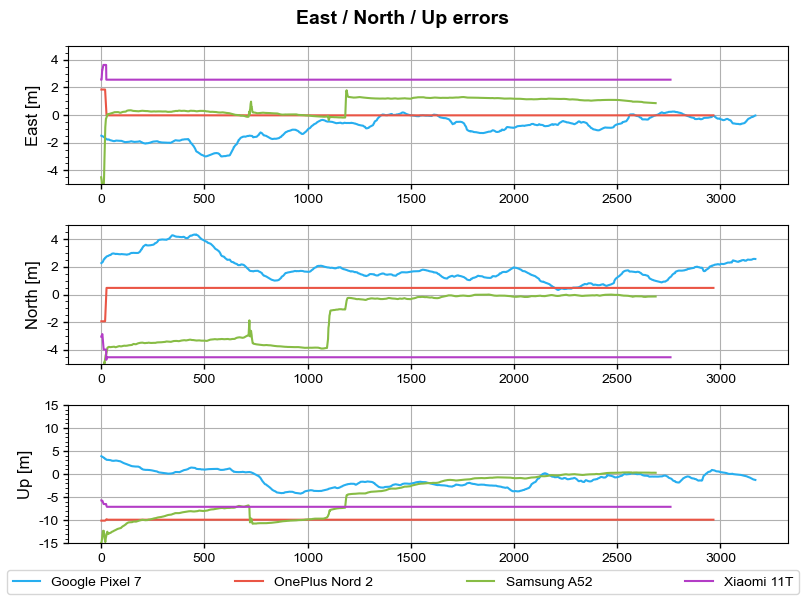

In [14]:
plotENU(logs)

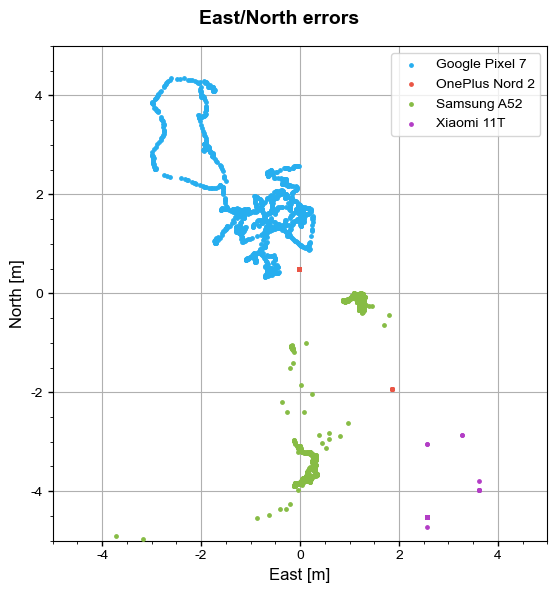

In [15]:
plotEN(logs)

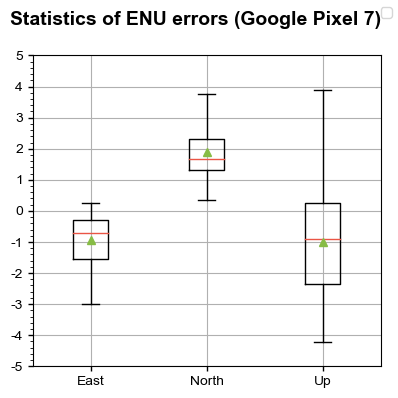

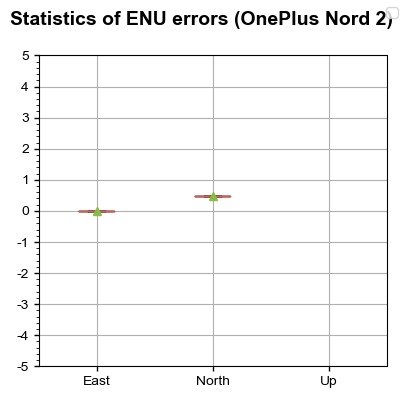

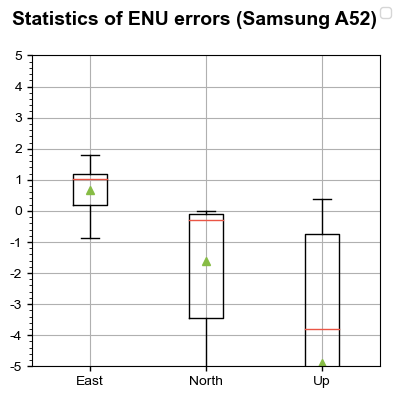

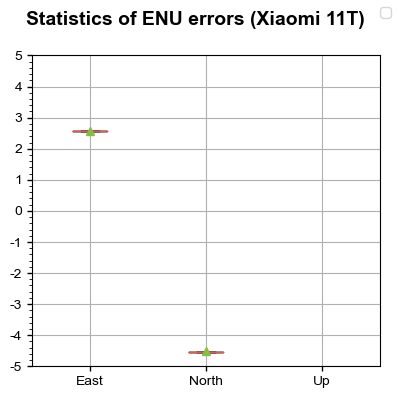

In [16]:
#plotHistENU(logs)
plotStatisticsENU(logs, mode='box')

# Measurement Analysis

In [17]:
# Plot histogram
def plotHistPerSystem(logs, systems, data_name, absolute=False):

    minor_ticks = 0.1
    major_ticks = 1
    lim = 60
    ylim = 0.6
    nb_bins = 31
    bins = np.linspace(0, lim, nb_bins)

    for log in logs:
        fig, axs = plt.subplots(1, figsize=(6,4))
        fig.suptitle(f"Histogram pseudorange errors ({log['device_name']})")

        sats = list(set(log['content'].raw["prn"]))
        sats.sort()

        # Find total absolute sum
        _sats = [item for item in sats if item.startswith(systems)]
        df = log['content'].raw.loc[log['content'].raw['prn'].isin(_sats), [data_name]]
        hist, edges = np.histogram(df[data_name], density=False, bins=bins)
        total_sum = hist.sum()

        bottom = np.zeros(nb_bins-1)
        for sys in systems:
            _sats = [item for item in sats if item.startswith(sys)]
            df = log['content'].raw.loc[log['content'].raw['prn'].isin(_sats), [data_name]]

            if absolute:
                df[data_name] = df[data_name].abs()
                bins = np.linspace(0, lim, nb_bins)
            else:
                bins = np.linspace(-lim, lim, nb_bins)
            hist, edges = np.histogram(df[data_name], density=False, bins=bins)
            unity_density = hist / hist.sum() / len(systems)
            axs.bar(x=edges[:-1], height=unity_density, align='center', 
                    width= 0.9 * (bins[1] - bins[0]), label=sys, zorder=3, bottom=bottom)
            bottom += unity_density
        
        # axs.xaxis.set_major_locator(MultipleLocator(major_ticks))
        # axs.xaxis.set_major_formatter('{x:.0f}')
        # axs.xaxis.set_minor_locator(MultipleLocator(minor_ticks))

        plt.ylim(0, ylim)

        handles, labels = axs.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.tight_layout()

#     if absolute:
#         df[data_name] = df[data_name].abs()

#     # Filter if neeeded
#     q = df[data_name].quantile(remove)
#     df[data_name] = df[df[data_name] < q]

#     data.append(df[data_name])

# axs.hist(data, nb_bins, range=(0, lim), density=True, rwidth=0.9, histtype='bar', stacked=True)

In [55]:
# Plot statistics data in violin
def plotStatisticsDataViolin(logs, data_name, ylabel, systems, frequencies=('L1','L5')):

    minor_ticks = 1
    major_ticks = 10
    lim = 60
    percentile = 0.999

    for log in logs:

        sats = list(set(log['content'].raw["prn"]))
        sats.sort()
        
        labels = []
        for sys in systems:
            labels.append(f"{getSystemStr(sys)}")

        _sats = [item for item in sats if item.startswith(systems)]
        _sats = [item for item in _sats if item.endswith(tuple([freq[-1] for freq in frequencies]))]
        
        df = log['content'].raw.loc[log['content'].raw['prn'].isin(_sats), ['prn', 'system', 'frequency', data_name]]
        
        # Filter if neeeded
        q = df[data_name].quantile(percentile)
        df = df[df[data_name].abs() < q]

        df.reset_index(drop=True, inplace=True)

        # Correction for mono-frequencies
        for sys in systems:
            _frequencies = list(set(df.loc[df['system'].isin([sys])]['frequency']))
            new_row = {'system':f'{sys}', 'frequency':'L1', data_name:float('nan')}
            
            if 'L1' not in _frequencies:
                new_row = [f'{sys}00-L1', f'{sys}', 'L1', float('nan')]
                df.loc[len(df.index)] = new_row
                df.loc[len(df.index)] = new_row
            elif 'L5' not in _frequencies:
                new_row = [f'{sys}00-L5', f'{sys}', 'L5', float('nan')]
                df.loc[len(df.index)] = new_row
                df.loc[len(df.index)] = new_row
        
        fig, axs = plt.subplots(1, figsize=(6,5))
        fig.suptitle(f"{log['device_name']}")

        sns.violinplot(ax=axs, data=df, x='system', y=data_name, hue='frequency', 
                       order=systems, hue_order=frequencies, legend=False,
                       split=True, orient='v', palette=['#27aeef', '#ef9b20'] , zorder=3)
        plt.setp(axs.collections, alpha=.7)

        axs.set_xticks([y for y in range(len(labels))], labels=labels)
        axs.set_xlabel('')
        axs.set_ylabel(ylabel)
        axs.legend(handles=axs.legend_.legend_handles, labels=frequencies)

        axs.yaxis.set_major_locator(MultipleLocator(major_ticks))
        axs.yaxis.set_major_formatter('{x:.0f}')
        axs.yaxis.set_minor_locator(MultipleLocator(minor_ticks))

        plt.ylim(0, lim)
        axs.set_axisbelow(True)
        # handles, labels = axs.get_legend_handles_labels()
        # fig.legend(handles, labels=frequencies)
        fig.tight_layout()


In [58]:
# Plot statistics data in box
def plotStatisticsDataBox(logs, data_name, ylabel, systems, frequencies):

    minor_ticks = 0.1
    major_ticks = 1
    lim = 60

    for log in logs:

        sats = list(set(log['content'].raw["prn"]))
        sats.sort()
        
        data = []
        labels = []
        for sys in systems:
            _sats = [item for item in sats if item.startswith(sys)]
            if sys == 'R':
                __sats = _sats
                df = log['content'].raw.loc[log['content'].raw['prn'].isin(__sats), [data_name]]

                # Filter if neeeded
                q = df[data_name].quantile(0.99)
                df[data_name] = df[df[data_name].abs() < q]

                _data = df[data_name]
                data.append(_data[~np.isnan(_data)])
                labels.append(f"{getSystemStr(sys)}")
            else:
                for freq in frequencies:
                    __sats = [item for item in _sats if item.endswith(freq[-1])]
                    df = log['content'].raw.loc[log['content'].raw['prn'].isin(__sats), [data_name]]

                    # Filter if neeeded
                    q = df[data_name].quantile(0.99)
                    df[data_name] = df[df[data_name].abs() < q]

                    _data = df[data_name]
                    _data = _data[~np.isnan(_data)].tolist()
                    
                    if len(_data) != 0:
                        data.append(_data)
                    else:
                        data.append([float('nan'), float('nan')])
                    labels.append(f"{getSystemStr(sys)}-{freq}")
        
        fig, axs = plt.subplots(1, figsize=(8,5))
        fig.suptitle(f"{data_name} errors ({log['device_name']})")
        axs.boxplot(data, showmeans=True, showfliers=False)
        axs.set_xticks([y + 1 for y in range(len(data))], labels=labels)
        axs.set_ylabel(ylabel)

        # axs.yaxis.set_major_locator(MultipleLocator(major_ticks))
        # axs.yaxis.set_major_formatter('{x:.1f}')
        # axs.yaxis.set_minor_locator(MultipleLocator(minor_ticks))

        plt.ylim(0, lim)
        axs.set_axisbelow(True)
        handles, labels = axs.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.tight_layout()


In [20]:
# Plot measurement
def plotMeasurement(log, data_name, sat):

    minor_ticks = 0.2
    major_ticks = 1
    lim = 0.5

    df = log['content'].raw.loc[log['content'].raw['prn'].isin(sat), ['datetime', 'prn', data_name]]

    fig, axs = plt.subplots(1, figsize=(6,5))
    fig.suptitle(f"{data_name} errors ({log['device_name']})")

    df.groupby('prn')[data_name].plot(x='datatime', y=data_name, ax=axs)

    # axs.yaxis.set_major_locator(MultipleLocator(major_ticks))
    # axs.yaxis.set_major_formatter('{x:.0f}')
    # axs.yaxis.set_minor_locator(MultipleLocator(minor_ticks))

    plt.ylim(-lim, lim)

    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()

### Pseudorange Analysis

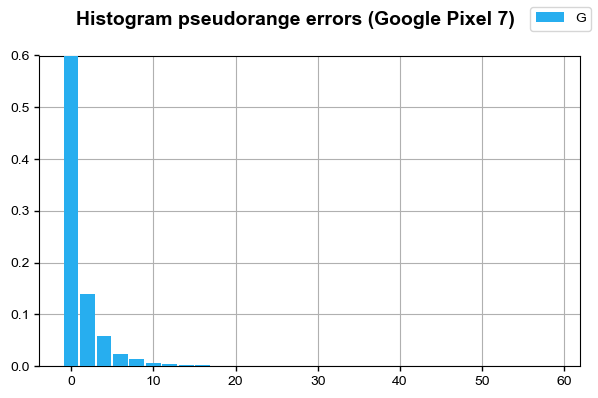

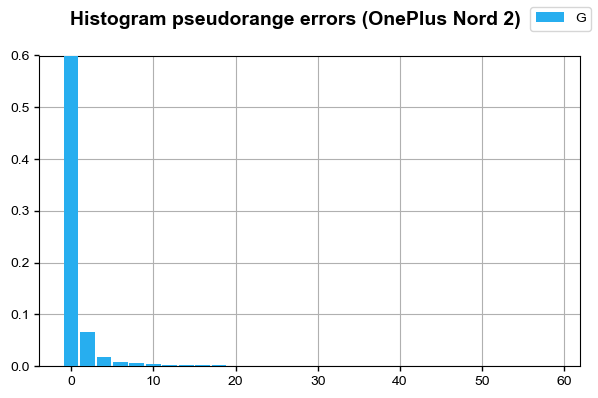

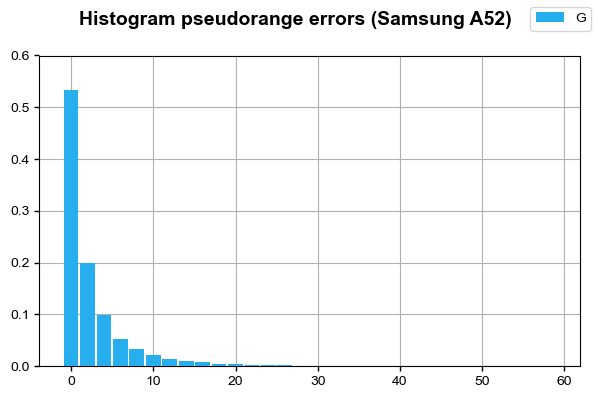

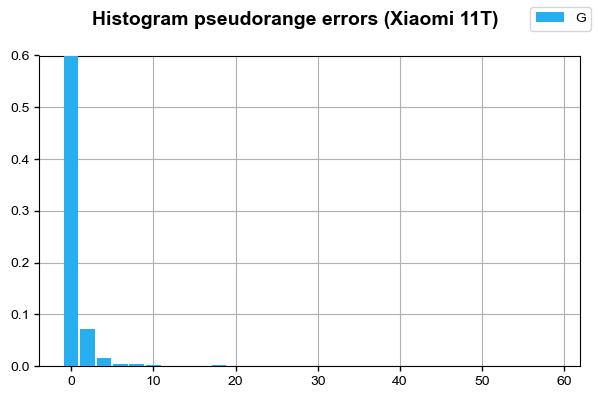

In [21]:
plotHistPerSystem(logs, ('G'), 'PseudorangeAcceleration', absolute=True)

In [22]:
plotStatisticsData(logs, 'PseudorangeAcceleration', ('G', 'R', 'E', 'C'), (1, 5), mode='box')

NameError: name 'plotStatisticsData' is not defined

## Doppler analysis

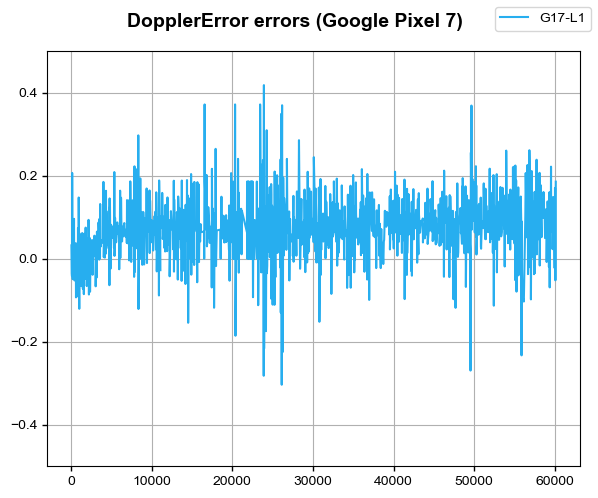

In [ ]:
plotMeasurement(logs[0], 'DopplerError', ['G17-L1'])

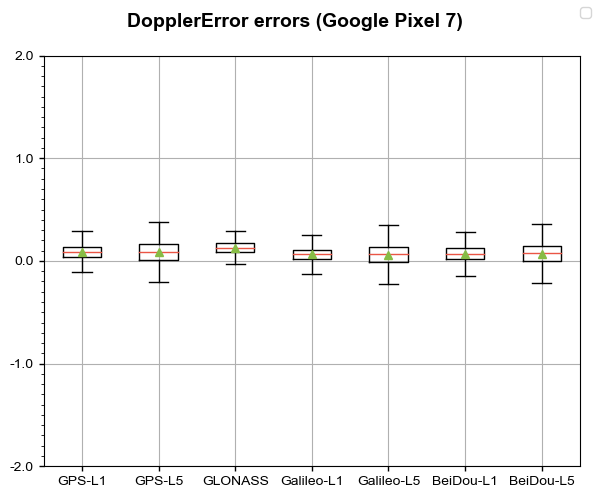

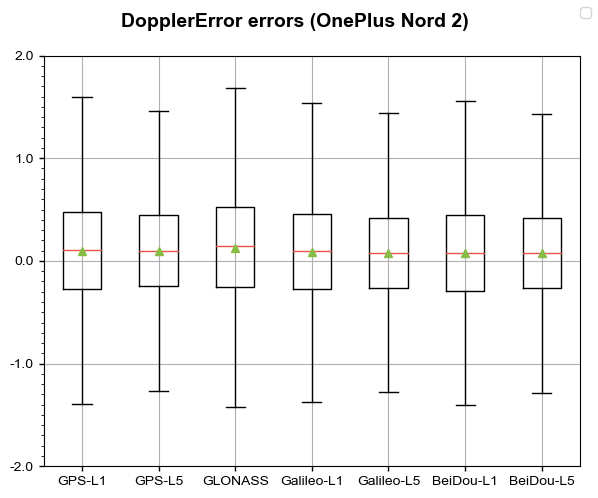

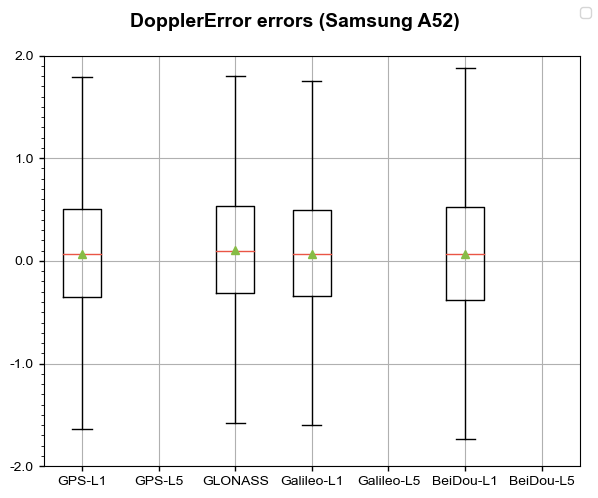

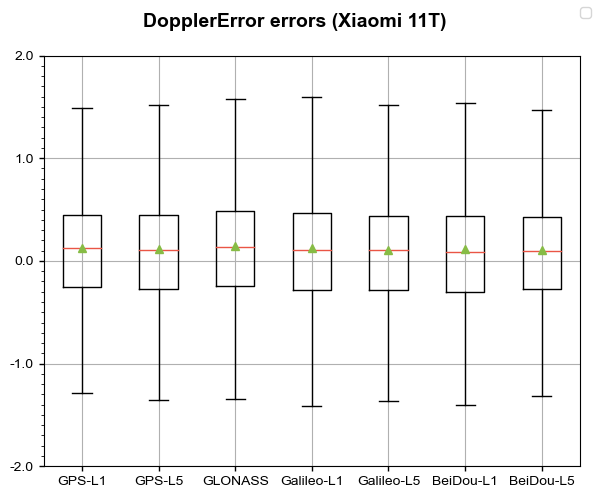

In [ ]:
plotStatisticsData(logs, 'DopplerError', ('G', 'R', 'E', 'C'), (1, 5), mode='box')

## Phase analysis

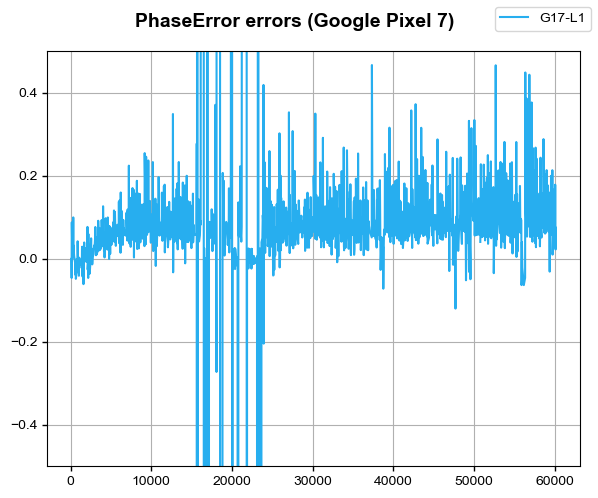

In [ ]:
plotMeasurement(logs[0], 'PhaseError', ['G17-L1'])

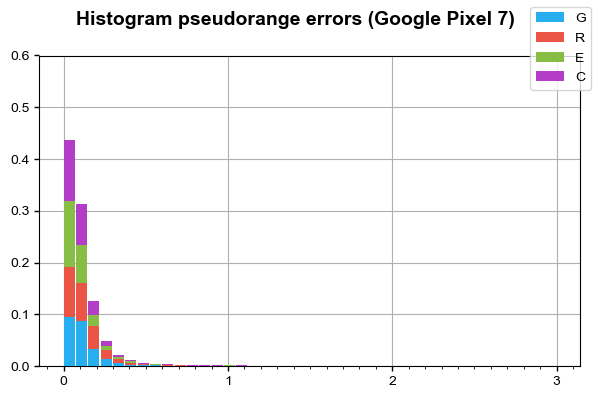

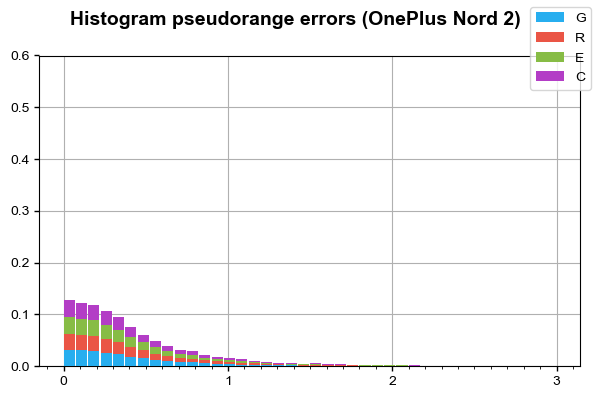

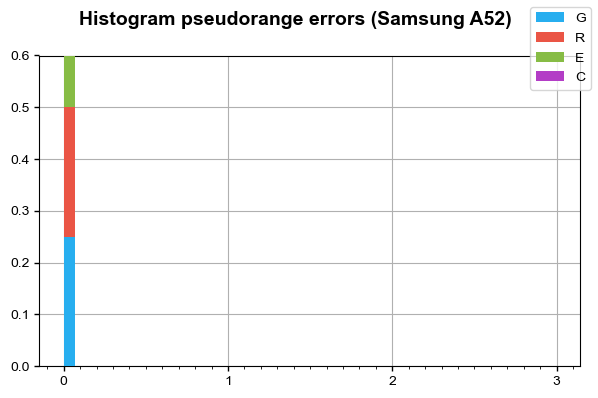

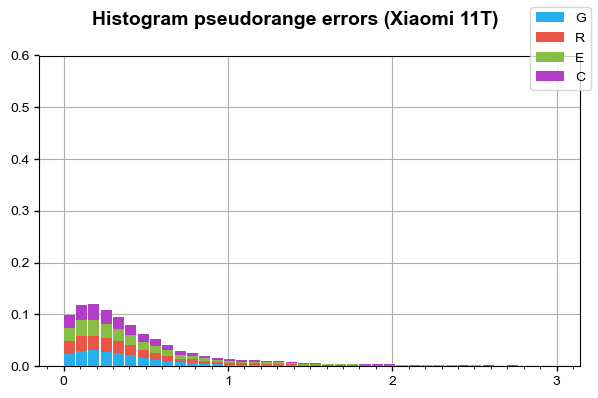

In [ ]:
plotHistPerSystem(logs, ('G', 'R', 'E', 'C'), 'PhaseError', absolute=True)

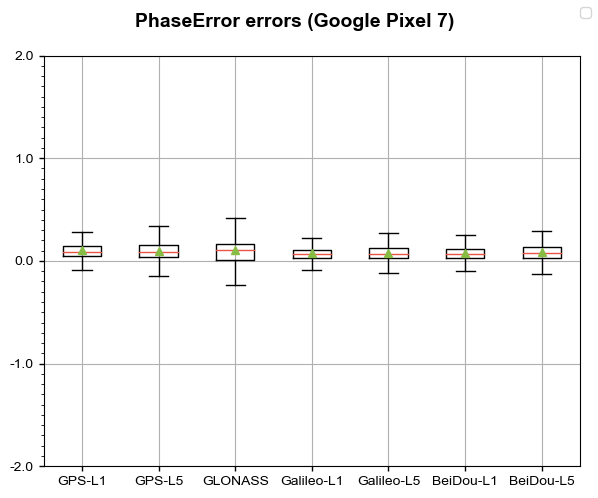

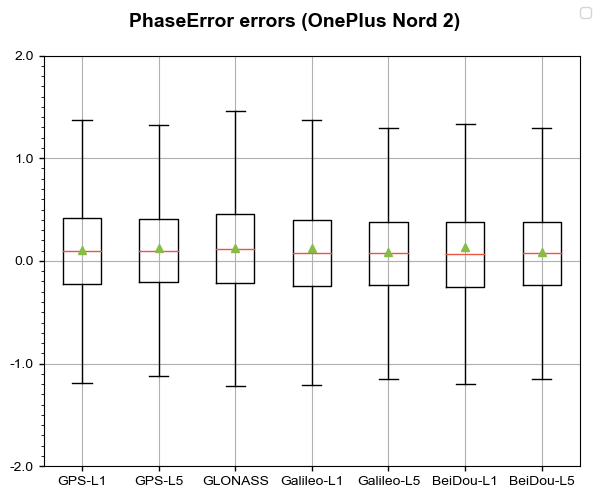

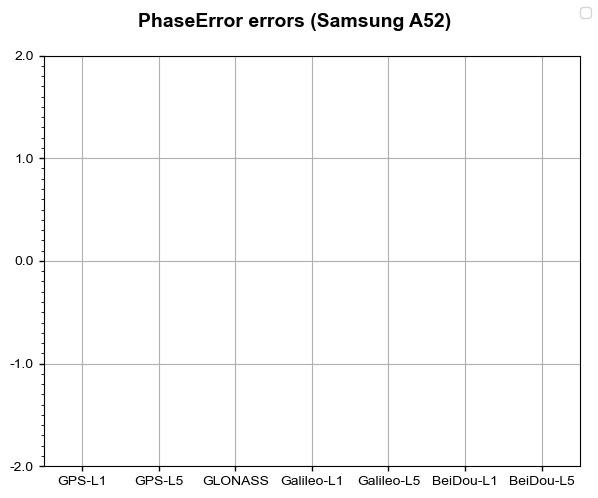

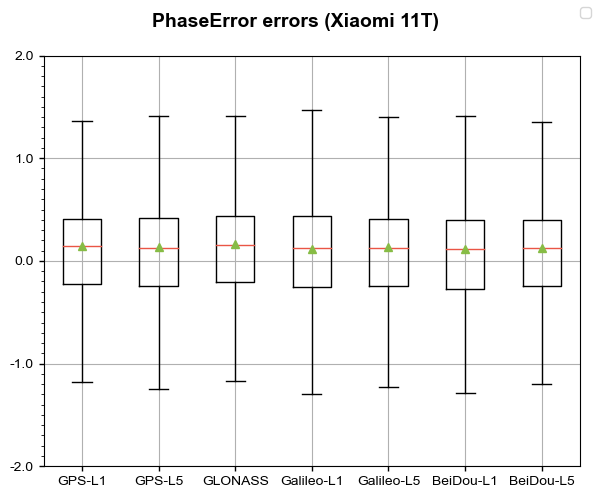

In [ ]:
plotStatisticsData(logs, 'PhaseError', ('G', 'R', 'E', 'C'), (1, 5), mode='box')

# Comparison with CN0
- only Cn0
- measurement wrt cn0

In [53]:
# Plot statistics data
def plotAgainstCn0(logs, data_name, systems, frequencies=[1,5]):

    minor_ticks = 0.1
    major_ticks = 1
    lim = 5
    outlier = 0.99

    for log in logs:

        fig, axs = plt.subplots(1, figsize=(6,5))
        fig.suptitle(f"{data_name} errors w.r.t C/N0 ({log['device_name']})")

        sats = list(set(log['content'].raw["prn"]))
        sats.sort()
        
        _sats = [item for item in sats if item.startswith(systems)]
        _sats = [item for item in _sats if item.endswith(frequencies)]

        df = log['content'].raw.loc[log['content'].raw['prn'].isin(_sats), ['Cn0DbHz', data_name]]
        df[data_name] = df[data_name].abs()
        
        # Filter if neeeded
        q = df[data_name].quantile(outlier)
        df = df[df[data_name].abs() < q]
        
        df.plot(x='Cn0DbHz', y=data_name, ax=axs, kind='scatter', s=3)

        # axs.yaxis.set_major_locator(MultipleLocator(major_ticks))
        # axs.yaxis.set_major_formatter('{x:.1f}')
        # axs.yaxis.set_minor_locator(MultipleLocator(minor_ticks))

        plt.ylim(0, lim)

        handles, labels = axs.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.tight_layout()

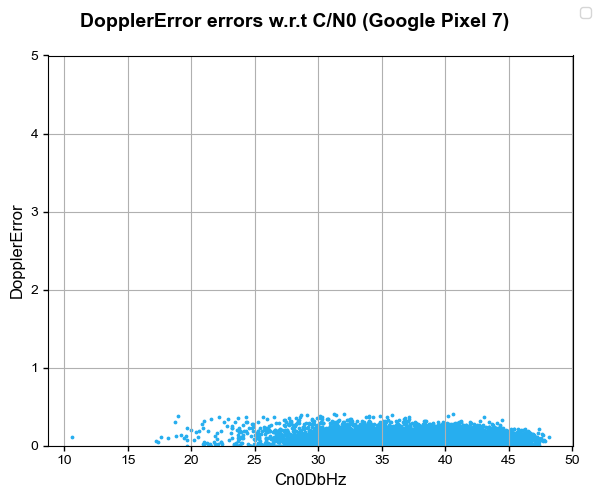

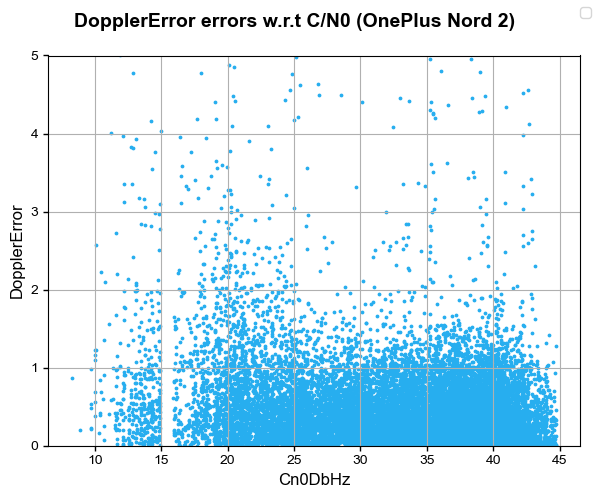

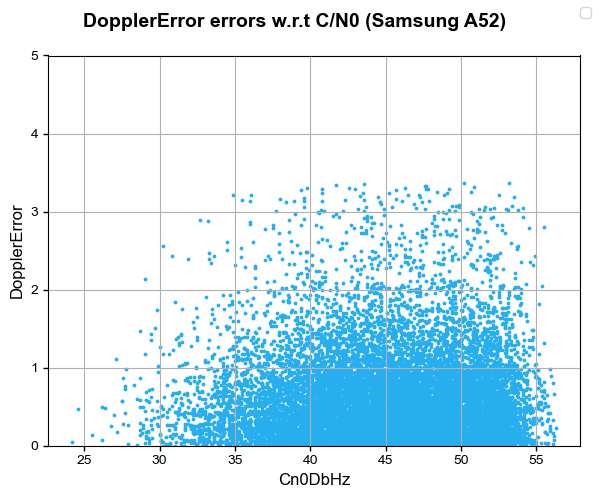

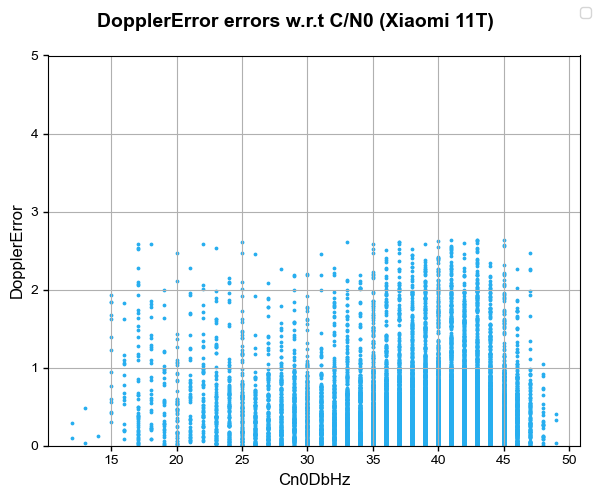

In [54]:
plotAgainstCn0(logs, 'DopplerError', ('G'), ('1'))

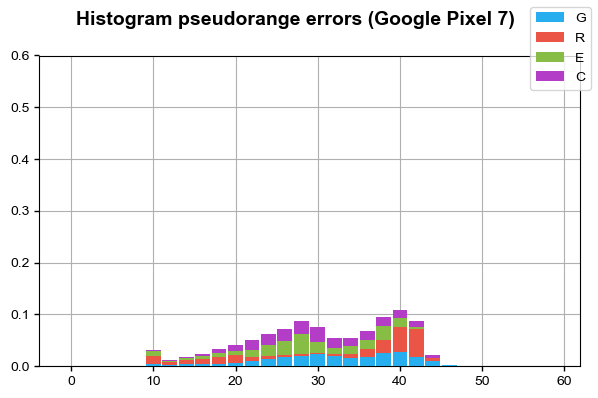

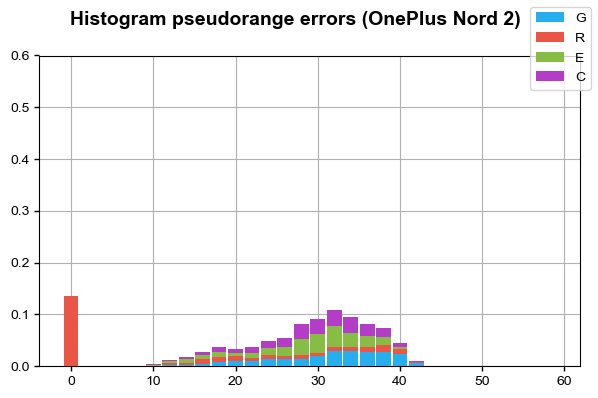

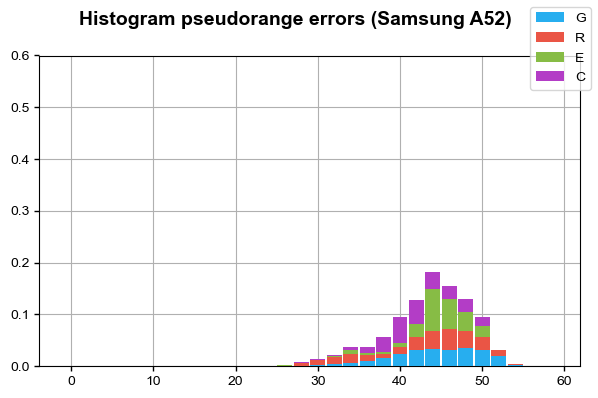

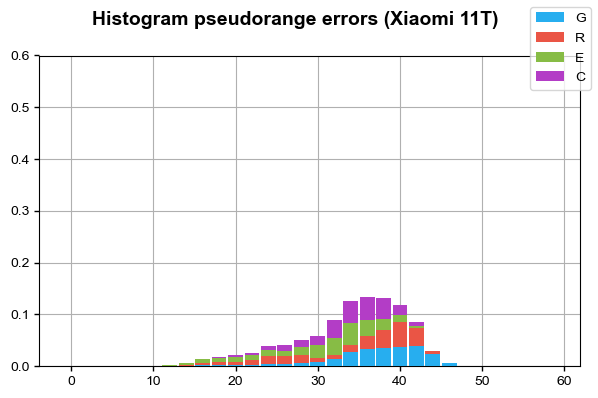

In [ ]:
plotHistPerSystem(logs, ('G', 'R', 'E', 'C'), 'Cn0DbHz', absolute=True)

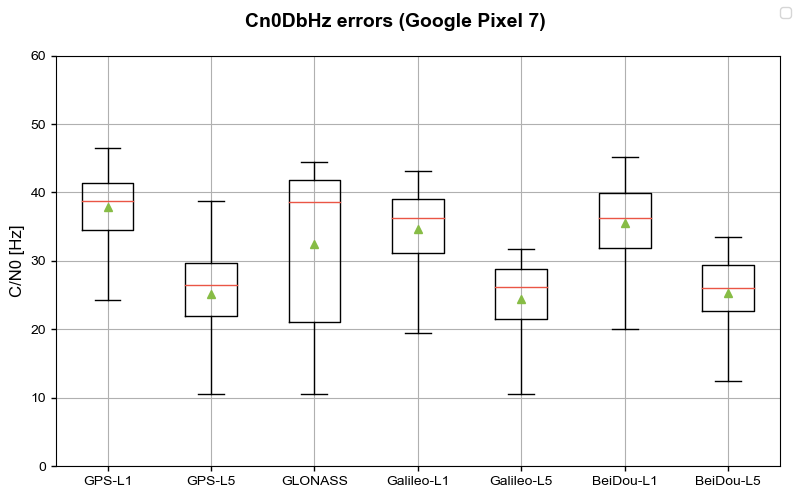

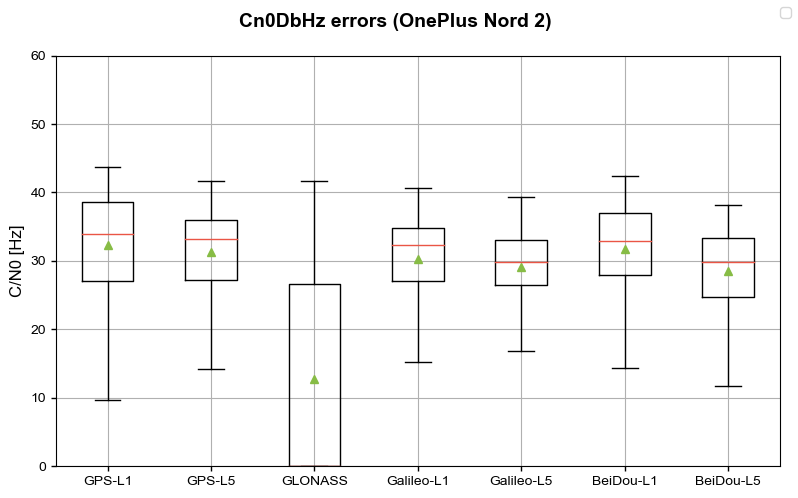

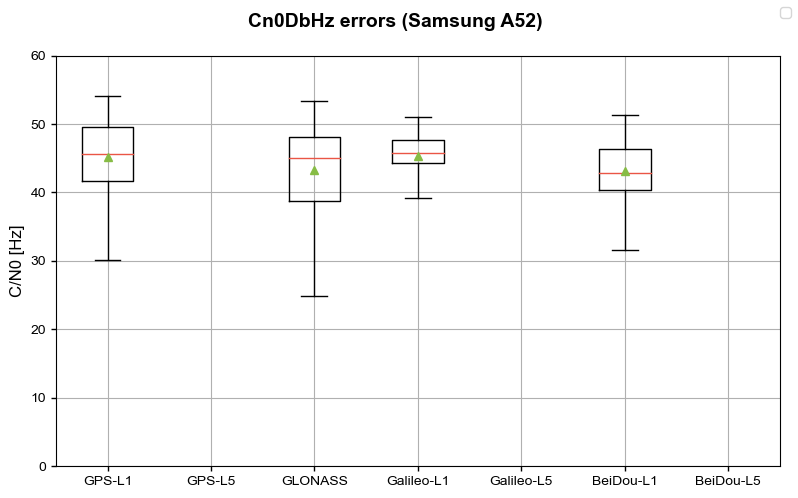

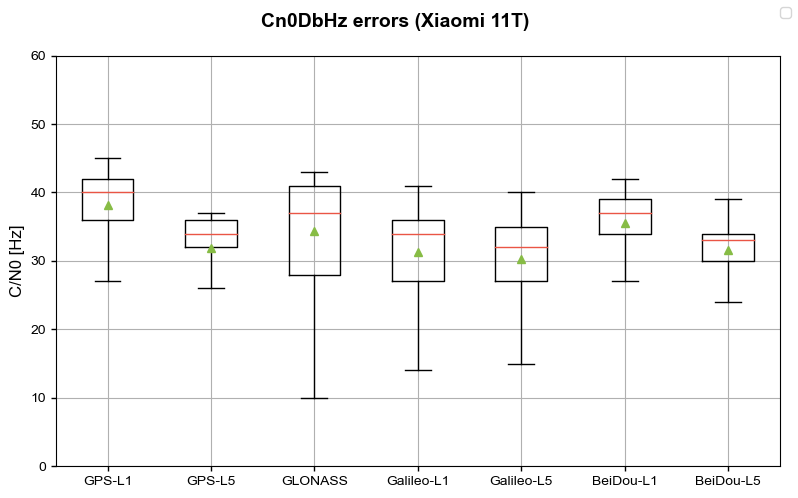

In [59]:
plotStatisticsDataBox(logs, 'Cn0DbHz', 'C/N0 [Hz]', ('G', 'R', 'E', 'C'), ('L1', 'L5'))

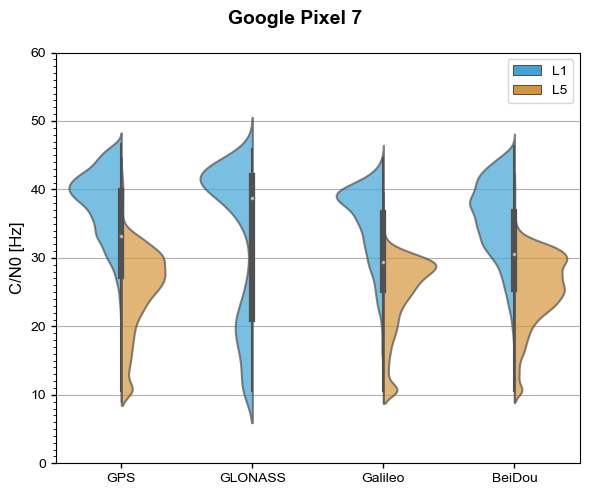

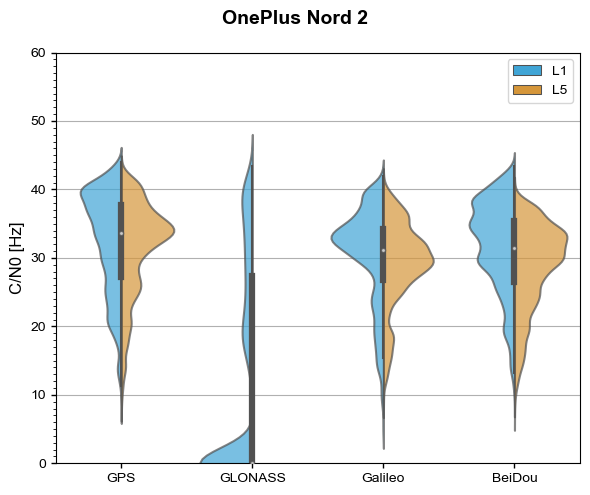

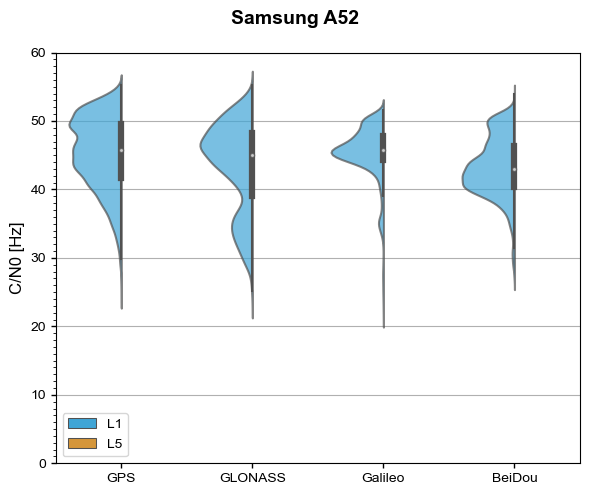

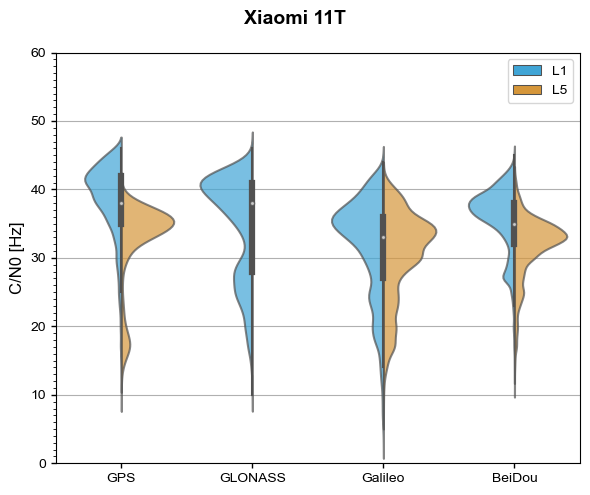

In [52]:
plotStatisticsDataViolin(logs, 'Cn0DbHz', 'C/N0 [Hz]', ('G', 'R', 'E', 'C'), ('L1', 'L5'))

# Comparison to base station